# LowCarb thorax disease classification in Flower

## Create dirs, get data, pull lowcarb repo

In [ ]:
!mkdir NIH
!mkdir /root/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


### Copy Kaggle API-key to created directory at '/root/.kaggle'

In [ ]:
!cp '/content/drive/MyDrive/professional/Research_Jobs/UMI/projects/APIs/kaggle.json' '/root/.kaggle'

In [ ]:
!kaggle datasets download -d nih-chest-xrays/data

100% 42.0G/42.0G [13:20<00:00, 60.1MB/s]
100% 42.0G/42.0G [13:20<00:00, 56.3MB/s]


In [ ]:
!unzip -q '/content/data.zip' -d '/content/NIH/'

In [ ]:
!cp -r /content/drive/MyDrive/carbonhack22/openapi_client /content/

In [ ]:
# Copy SSH key to access carbonhack22 GitHub repo
!cp -r /content/drive/MyDrive/carbonhack22/.ssh ~/

In [ ]:
!git clone git@github.com:birnbaum/carbonhack22.git
%cd carbonhack22

Cloning into 'carbonhack22'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 331 (delta 0), reused 2 (delta 0), pack-reused 322
Receiving objects: 100% (331/331), 1.43 MiB | 1.23 MiB/s, done.
Resolving deltas: 100% (159/159), done.
/content/carbonhack22


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./carbon_sdk_client
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 8.8 MB 36.1 MB/s 
     |████████████████████████████████| 140 kB 71.4 MB/s 
     |████████████████████████████████| 9.8 MB 60.6 MB/s 
     |████████████████████████████████| 346 kB 69.7 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 423 kB 73.6 MB/s 
     |████████████████████████████████| 271 kB 73.7 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████

## Check GPU availability

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct 24 18:35:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create dirs, get data 

In [ ]:
# !mkdir NIH
# !mkdir /root/.kaggle/

### Copy Kaggle API-key to created directory at '/root/.kaggle'

In [ ]:
# !cp '/content/drive/MyDrive/professional/Research_Jobs/UMI/projects/APIs/kaggle.json' '/root/.kaggle'

In [ ]:
# !kaggle datasets download -d nih-chest-xrays/data

100% 42.0G/42.0G [11:09<00:00, 63.4MB/s]
100% 42.0G/42.0G [11:09<00:00, 67.3MB/s]


In [ ]:
# !unzip -q '/content/data.zip' -d '/content/NIH/'

## Install packages

In [ ]:
!pip install flwr[simulation]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 7.4 MB/s 
     |████████████████████████████████| 1.0 MB 59.7 MB/s 
     |████████████████████████████████| 54.5 MB 143 kB/s 
     |████████████████████████████████| 8.8 MB 55.5 MB/s 
     |████████████████████████████████| 4.1 MB 57.2 MB/s 
     |████████████████████████████████| 57 kB 6.2 MB/s 
     |████████████████████████████████| 3.0 MB 60.9 MB/s 
     |████████████████████████████████| 90 kB 9.1 MB/s 
     |████████████████████████████████| 201 kB 66.3 MB/s 
     |████████████████████████████████| 128 kB 73.7 MB/s 
     |████████████████████████████████| 291 kB 52.2 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
     |████████████████████████████████| 468 kB 56.5 MB/s 
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19889 sha256=0a57736a083f03aafbe0e232321bba1b990c59c84c5ef94d558b1ee0e09fe218
  S

## Imports

In [1]:
%cd carbonhack22

/content/carbonhack22


In [2]:
import os
import sys
import math
import time
from glob import glob
from PIL import Image
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nnqunt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms as T, models

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training on cuda:0


## Data utils

In [3]:
from PIL import Image
from itertools import chain

import numpy as np
import pandas as pd

from torch.utils.data import Dataset

class NIH_Dataset(Dataset):
  """
  Main Dataset class to represent NIH Chest X-Ray data
  ...
  Attributes
  ----------
  data_df: pandas.DataFrame
    A DataFrame that needs to at least have the following two columns: 
      1. "path": Holds chest x-ray image locations
      2. "disease_vec": Holds multilabel one-hot encoded vector
  transform: torchvision.transform.Compose
    Image transformations that will be applied to each image when calling "__getitem__"
  """
  def __init__(
    self, 
    data_df,
    transform=None
    ) -> Dataset:
    """
    Parameters
    ----------
    data_df: pandas.DataFrame
      A DataFrame that needs to at least have the following two columns: 
        1. "path": Holds chest x-ray image locations
        2. "disease_vec": Holds multilabel one-hot encoded vector
    transform: torchvision.transform.Compose
      Image transformations that will be applied to each image when calling "__getitem__"
    """
    self.data_df = data_df
    self.transform = transform 

  def __len__(
    self
    ) -> int:
    return len(self.data_df)

  def __getitem__(
    self, 
    idx
    ) -> Tuple[torch.Tensor, np.ndarray]:
    img_file = self.data_df['path'].iloc[idx]
    img = Image.open(img_file).convert('RGB')
    label = np.array(self.data_df.iloc[:,-1].iloc[idx], dtype=float)
    if self.transform:
        img = self.transform(img)

    return img, label

In [4]:
def load_and_preprocess_data_df(
    data_df_root_path: str,
    num_data_samples: int = 11000
    ) -> Tuple[pd.DataFrame, List]:
  """
  Loads and preprocesses NIH DataFrame that holds information of the data, e.g. image labels.

  Parameters
  ----------
  data_df_root_path: str
    This should be the path to the root directory of the NIH data set that, 
    at least, includes the img-file directories and the panda.DataFrame 
    "Data_Entry_2017.csv". The direcotry should have the following structure:

    NIH
      |
      images_0**
      ...
      Data_Entry_2017.csv
      ...
      train_val_list.txt

  num_data_samples: int
    The total number of data points that we want to sample for our data set.
    Maximum is 112120.
  """

  # Load the DataFrame
  all_xray_df = pd.read_csv(
      os.path.join(
          data_df_root_path,
          'Data_Entry_2017.csv'
          )
      )
  
  # Extract all image paths
  all_image_paths = {
      os.path.basename(x): x for x in 
      glob(os.path.join(data_df_root_path, 'images*', '*', '*.png'))
      }

  # Add image file name column
  all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
  
  # Count labels
  all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))  
  all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
  all_labels = [x for x in all_labels if len(x)>0]
  for c_label in all_labels:
      if len(c_label)>1: # leave out empty labels
          all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
  MIN_CASES = 1000
  all_labels = [
      c_label for c_label in all_labels if all_xray_df[c_label].sum() > MIN_CASES
      ]
  sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
  sample_weights /= sample_weights.sum()
  preprocessed_xray_df = all_xray_df.sample(num_data_samples, weights=sample_weights)
  # Create one-hot encoding of the vector
  preprocessed_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
  return preprocessed_xray_df, all_labels


In [5]:
def inv_data_transform(
    img: torch.Tensor
    ) -> torch.Tensor:
  """
  Helper function that un-normalizes torch image tensor
  """
  img = img.permute(1,2,0)
  img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
  return img

def get_data_loaders(
    data_df_root_path: str,
    num_data_samples: int = 11000,
    global_train_frac: float = 0.8,
    local_train_frac: float = 0.8,
    batch_size: int = 32,
    num_clients: int = 10
    ) -> Tuple[Tuple[DataLoader, ...], Tuple[DataLoader, ...], DataLoader, List]:

  """
  Main function to create DataLoaders of the NIH X-Ray data set.
  
  Parameters
  ----------
  data_df_root_path: str
    This should be the path to the root directory of the NIH data set that, 
    at least, includes the img-file directories and the panda.DataFrame 
    "Data_Entry_2017.csv". The direcotry should have the following structure:
    NIH
      |
      images_0**
      ...
      Data_Entry_2017.csv
      ...
      train_val_list.txt

  num_data_samples: int
    The total number of data points that we want to sample for our data set.
    Maximum is 112120.

  global_train_frac: float
    The fraction of points used for the global training data set, e.g. the data set that will be later split into local client data sets.

  local_train_frac: float
      The fraction of points on each local client used for training.

  batch_size: int
    Batch size on each client

  num_clients: int
    Total number of clients in the FL setup

  Returns
  -------
  trainloaders: List[torch.utils.data.DataLoader, ...]
    List of local training DataLoaders, one for each client

  valloaders: List[torch.utils.data.DataLoader, ...]
    List of local calidation DataLoaders, one for each client

  testloader: torch.utils.data.DataLoader
    Global test DataLoader, for the central server
  
  all_labels: List[str, ...]
    List of all string labels

  preprocessed_data_df: pd.DataFrame
    preprocessed Dataframe that represents the data
  """
  
  preprocessed_xray_df, all_labels = load_and_preprocess_data_df(
      data_df_root_path,
      num_data_samples
  )

  train_data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])

  test_data_transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])
  
  train_df, test_df = train_test_split(
      preprocessed_xray_df,
      test_size = 1 - global_train_frac,
      random_state = 42,
      stratify = preprocessed_xray_df['Finding Labels'].map( lambda x: x[:4])
  )

  trainset = NIH_Dataset(
      train_df,
      transform = train_data_transform
      )
  
  testset = NIH_Dataset(
      test_df,
      transform = test_data_transform
      )

  # Split training set into `num_clients` partitions to simulate different local datasets
  partition_size = len(trainset) // num_clients
  lengths = [partition_size] * num_clients
  lengths[-1] += len(trainset) - np.sum(lengths)
  datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

  # Split each partition into train/val and create DataLoader
  trainloaders = []
  valloaders = []
  for ds in datasets:      
      len_train = math.ceil(len(ds) * local_train_frac)
      len_val = len(ds) - math.ceil(len(ds) * local_train_frac)
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last = True))
      valloaders.append(DataLoader(ds_val, batch_size=batch_size, drop_last = True))
  testloader = DataLoader(testset, batch_size=batch_size)

  return trainloaders, valloaders, testloader, all_labels, preprocessed_xray_df

## Load the data

In [6]:
num_clients = 10

data_df_root_path = '/content/NIH/'
num_data_samples = 11000
global_train_frac = 0.95
local_train_frac = 0.9
batch_size = 2

trainloaders, valloaders, testloader, all_labels, preprocessed_xray_df = get_data_loaders(
    data_df_root_path = data_df_root_path,
    num_clients = num_clients,
    num_data_samples = num_data_samples,
    global_train_frac = global_train_frac,
    local_train_frac = local_train_frac,
    batch_size = batch_size
)

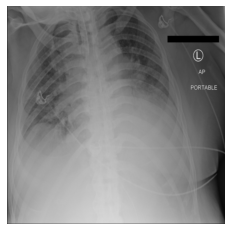

In [7]:
plt.imshow(
    inv_data_transform(
        testloader.dataset[0][0]
    )
)
plt.axis('off');

In [8]:
len(trainloaders[0].dataset), len(valloaders[0].dataset) ,len(testloader.dataset), len(all_labels)

(940, 104, 551, 13)

### Lowcarb utils

In [10]:
from logging import INFO
from typing import Dict, List, Optional
import random

import pandas as pd
from flwr.common.logger import log

import flwr as fl
from flwr.server.client_manager import ClientManager
from flwr.server.criterion import Criterion
from flwr.server.client_proxy import ClientProxy

import requests
from pandas import DataFrame
from ray.exceptions import RaySystemError

from backtest.strategy import CarbonAwareStrategy

from lowcarb.carbon_sdk_webapi import CarbonSDK_WebAPI

import numpy as np

class Object(object):
    pass

class LowCarb_ClientManager(fl.server.client_manager.SimpleClientManager):
    '''
    Implementation of lowcarbs ClientManager, which is a simple extension of flower's own standard SimpleClientManager.
    lowcarb achieves carbon aware federated learning by implementing the sample() method to select clients in a way to minmize the carbon foodprint while maintaining net integrity.
    '''
    def __init__(self, api_host, workload_duration=15, forecast_window=12, **kargs):
        super(LowCarb_ClientManager, self).__init__(**kargs)
        self.host = api_host
        self.api = CarbonSDK_WebAPI(self.host)
        self.workload_duration = workload_duration
        self.forecast_window = forecast_window

        self.client_participation: dict[str: int] = {}

    def sample(
            self,
            num_clients: int,
            min_num_clients: Optional[int] = None,
            criterion: Optional[Criterion] = None,
    ) -> List[ClientProxy]:

        ##### each sample round add any new client to the participitation DataFrame
        for cid in list(self.clients.keys()):
            if not (cid in self.client_participation.keys()):
                self.client_participation[cid] = 0


        """Sample a number of Flower ClientProxy instances."""
        # Block until at least num_clients are connected.
        if min_num_clients is None:
            min_num_clients = num_clients
        self.wait_for(min_num_clients)
        # Sample clients which meet the criterion
        available_cids = list(self.clients)
        if criterion is not None:
            available_cids = [
                cid for cid in available_cids if criterion.select(self.clients[cid])
            ]

        if num_clients > len(available_cids):
            log(
                INFO,
                "Sampling failed: number of available clients"
                " (%s) is less than number of requested clients (%s).",
                len(available_cids),
                num_clients,
            )
            return []

        # Sampled_cids = random.sample(available_cids, num_clients)

        # Data for the strategy to select the next best clients
        client_locations = self._get_client_locations()

        print(client_locations)

        present_locations = pd.Series(client_locations.values()).unique()
        forecasts = self._get_location_forecasts(present_locations)

        available_cids_participation = {cid: self.client_participation[cid] for cid in available_cids}

        strategy = CarbonAwareStrategy(clients_per_round=num_clients, max_forecast_duration=self.forecast_window)
        selected_clients = strategy.select(forecasts=forecasts, past_participation=available_cids_participation, client_location_map=client_locations)

        for client in selected_clients:
            self.client_participation[client] = self.client_participation[client] + 1

        print('_______________________________________________________________________\n Available Clients with their locations\n_______________________________________________________________________')
        for client, location in client_locations.items():
            print(f'{client} {location}')

        print('_______________________________________________________________________\n Available Clients with their participation\n_______________________________________________________________________')
        for client, participation in available_cids_participation.items():
            print(f'{client} {participation}')

        print('_______________________________________________________________________\n selected low carbon clients\n_______________________________________________________________________')
        for client in selected_clients:
            print(f'{client}')
        
        print('_______________________________________________________________________\n CO2 intensity of selected clients\n_______________________________________________________________________')
        for client in selected_clients:
            print(f'Client: {client}, CO2 intensity: {forecasts[client_locations[client]]}')

        return [self.clients[cid] for cid in selected_clients]

        # return [self.clients[cid] for cid in sampled_cids]

    def _get_client_locations(self) -> Dict[str, str]:
        '''
        Fetches all the clients' location and puts it in a DataFrame
        :return: pandas Dataframe with 'cid' and 'location' column
        '''
        client_props = []
        for cid, client in self.clients.items():
            Ins = Object()  ##### weird hack for gRPC, I guess the Ins for get_properties are missing in flwr
            Ins.config = {'config_value': 'config_sample_value'}
            try:
                client_prop = client.get_properties(ins=Ins, timeout=500)
                client_prop.properties.update({'cid': cid})
                client_props.append(client_prop.properties)
            except RaySystemError as error:
                print(error)

        location_df = pd.DataFrame({
            'cid': [client_prop['cid'] for client_prop in client_props],
            'location': [client_prop['location'] for client_prop in client_props]
        })

        client_locations = {client['cid']: client['location'] for i, client in
                                location_df.iterrows()}

        return client_locations

    def _get_location_forecasts(self, locations) -> Dict[str, list]:
        forecasts_response = self.api.get_forecast_batch(locations, windowSize=self.workload_duration, forecast_window=self.forecast_window)
        forecasts = {region: forecast['value'].to_list() for region, forecast in forecasts_response.groupby('region')}
        return forecasts

In [11]:
class Lowcarb_Client(object):
    def __init__(self, *args, **kwargs):
        super(Lowcarb_Client, self).__init__(*args, **kwargs)
        self.location = None

    def get_properties(self, config):
        return {'location': self.location}

def lowcarb(func):
    def wrapper(*args):
        properties = func(*args)
        properties['location'] = args[0].location

        return properties

    return wrapper

### FL utils basic

In [12]:
class FlowerClient(Lowcarb_Client, fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, location, *args, **kwargs):
        super(FlowerClient, self).__init__(*args, **kwargs)
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

        self.location = location

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        # server_round = config["server_round"]
        # local_epochs = config["local_epochs"]
        local_epochs = 30

        # Use values provided by the config
        # print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    # print('Entered set params function')
    params_dict = zip(net.state_dict().keys(), parameters)
    # print('Created params dict')
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # print('Created state dict')
    # print([k for k in state_dict.keys()])
    # print([k for k in net.state_dict().keys()])
    try:
      net.load_state_dict(state_dict, strict=True)
      print('Finished loading model weights')
    except:
      print('Failed to load state dict')

### FL training utils

In [13]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon = 1e-7):
    y_pred = torch.sigmoid(y_pred)
    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

def train(
    net,
    trainloader,
    epochs
    ):
    print(f'Entered train function, total num. of epochs: {epochs}')
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(preprocessed_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    valid_loss_min = np.Inf
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = 1e-4
        )
    start_time = time.time()
    for i in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0 
        net.train()
        for j, (images, labels) in enumerate(trainloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            ps = net(images)
            
            loss = weighted_loss(pos_weights, neg_weights, ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(trainloader)
        print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    end_time = time.time()
    time_delta = end_time - start_time
    print('\n')
    print(f'Time to complete local training round: {time_delta}')
    print('\n')

def test(net, testloader, pathology_list):
    
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(preprocessed_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset)) * 100.0 for i in per_class_accuracy]

    return loss, np.mean(per_class_accuracy)

def get_acc_data(
    class_names,
    acc_list
    ):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Class Acc.']) 
    return df

In [14]:
def server_eval(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar]
    ):
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(preprocessed_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    net = init_net().to(DEVICE)

    set_parameters(net, parameters)  # Update model with the latest parameters

    per_class_accuracy = [0 for i in range(len(all_labels))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
          
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            ps = torch.sigmoid(ps)
            ps = (ps >= 0.5).float()
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset))*100.0 for i in per_class_accuracy]

    test_df = get_acc_data(all_labels, per_class_accuracy)
    print('\nServer eval')
    print(test_df)
    print('\n')

    return loss,  {"mean_class_acc.": np.mean(per_class_accuracy)}

## Training

In [15]:
from random import sample
def init_net():
  net = models.vgg11(
    weights=None
  )
  net.classifier[-1] = torch.nn.Linear(
      net.classifier[-1].in_features,
      len(all_labels)
  )
  return net

available_regions = ['westcentralus', 'ukwest', 'uksouth', 'westeurope', 
                     'westus', 'australiacentral', 'australiaeast', 
                     'swedencentral', 'norwaywest', 'norwayeast', 'northeurope',
                     'centralus', 'francesouth', 'francecentral']

regions = [
    sample(available_regions, 1)[0] for i in range(0, num_clients)
    ]

def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = init_net().to(DEVICE)

    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    print(f'Created client: {cid}')

    return FlowerClient(net, trainloader, valloader, regions[int(cid)])

### 35 local epochs take approx 15min. on A100 for each client and 30 local epochs on Tesla T4 

In [16]:
num_clients

10

In [ ]:
num_rounds = 10
local_epochs = 30
fraction_fit = 0.05
fraction_evaluate = 0.05
min_fit_clients = 5
min_evaluate_clients = 5

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

# def fit_config(server_round: int):    
#     config = {
#         "server_round": server_round,
#         "local_epochs": local_epochs,
#     }
#     return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    # evaluate_fn=server_eval,
    # on_fit_config_fn=fit_config,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    client_resources=client_resources,
    client_manager=LowCarb_ClientManager(api_host='https://carbon-aware-api.azurewebsites.net', workload_duration=15, forecast_window=12),
    strategy=strategy,
)

INFO flower 2022-10-24 21:10:18,525 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2022-10-24 21:10:22,968 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 8003992782.0, 'accelerator_type:T4': 1.0, 'node:172.28.0.2': 1.0, 'CPU': 2.0, 'object_store_memory': 4001996390.0, 'GPU': 1.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'memory': 8003992782.0, 'accelerator_type:T4': 1.0, 'node:172.28.0.2': 1.0, 'CPU': 2.0, 'object_store_memory': 4001996390.0, 'GPU': 1.0}
INFO flower 2022-10-24 21:10:22,976 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-24 21:10:22,982 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-24 21:10:22,990 | server.py:88 | Eval

(launch_and_get_properties pid=9132) Created client: 0
(launch_and_get_properties pid=9179) Created client: 1
(launch_and_get_properties pid=9224) Created client: 2
(launch_and_get_properties pid=9269) Created client: 3
(launch_and_get_properties pid=9314) Created client: 4
(launch_and_get_properties pid=9359) Created client: 5
(launch_and_get_properties pid=9405) Created client: 6
(launch_and_get_properties pid=9450) Created client: 7
(launch_and_get_properties pid=9495) Created client: 8
{'0': 'norwaywest', '1': 'northeurope', '2': 'westcentralus', '3': 'northeurope', '4': 'westeurope', '5': 'francecentral', '6': 'northeurope', '7': 'australiacentral', '8': 'australiacentral', '9': 'westeurope'}
(launch_and_get_properties pid=9542) Created client: 9


DEBUG flower 2022-10-24 21:11:30,449 | server.py:220 | fit_round 1: strategy sampled 5 clients (out of 10)
DEBUG:flower:fit_round 1: strategy sampled 5 clients (out of 10)


_______________________________________________________________________
 Available Clients with their locations
_______________________________________________________________________
0 norwaywest
1 northeurope
2 westcentralus
3 northeurope
4 westeurope
5 francecentral
6 northeurope
7 australiacentral
8 australiacentral
9 westeurope
_______________________________________________________________________
 Available Clients with their participation
_______________________________________________________________________
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
_______________________________________________________________________
 selected low carbon clients
_______________________________________________________________________
7
8
0
4
9
_______________________________________________________________________
 CO2 intensity of selected clients
_______________________________________________________________________
Client: 7, CO2 intensity: [821.7633264085555, 821.5783162393334, 821.006157